In [1]:
import pandas as pd
import pyarrow.parquet as pq
from sklearn.metrics import classification_report
RANDOM_SEED = 42
batch_size = 1000000

In [2]:
#df = pd.read_parquet("/kaggle/input/competicion-q-no-me-deja-sino/data/train.parquet")
df = pd.read_parquet("/kaggle/input/patata-spacecraft-comp-qsinonova-reducido/reduced.parquet")
print(df.shape)
df.head()

(14728321, 7)


,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
0,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
1,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
2,0.821213,0.789557,0.770317,0.809411,0.816006,0.765296,0
3,0.819642,0.786344,0.770317,0.807050,0.816855,0.766985,0
4,0.821996,0.788753,0.770317,0.807837,0.818551,0.761073,0


In [3]:
# empezamos usando solo las columnas que segun los creadores mejor funcionan
best_channels = ["channel_41","channel_42","channel_43","channel_44","channel_45","channel_46"]
reduced_df = df[best_channels + ['is_anomaly']].copy()

In [4]:
# generamos un parquet con los atributos mas importantes ya que sino no cab en ram
#df[best_channels + ['is_anomaly']].to_parquet("reduced.parquet", index=False)

Dado que tenemos varios canales y no sabemos si las anomalias se producen por uno u otro, estamos ante un problema de anomalias multivariantes.
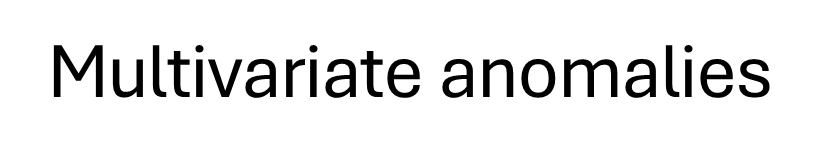
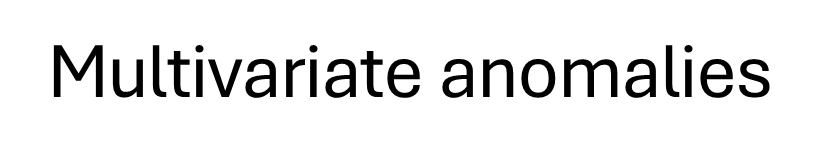
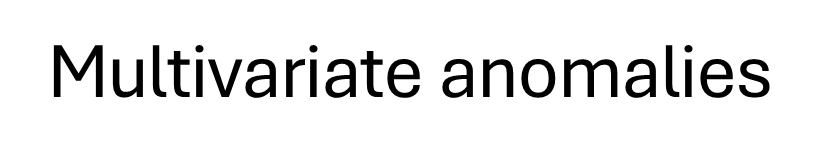
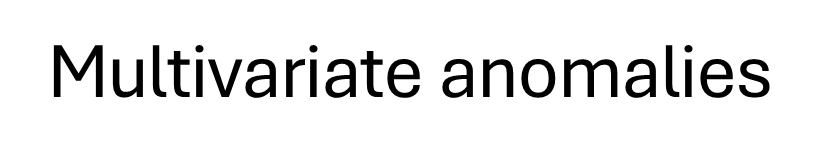
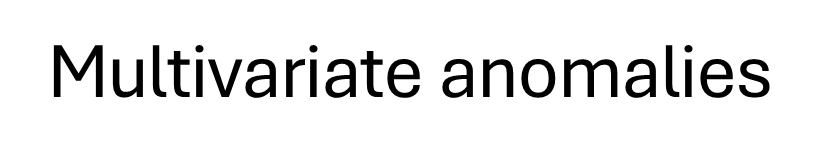
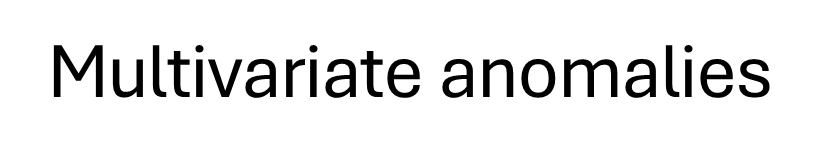
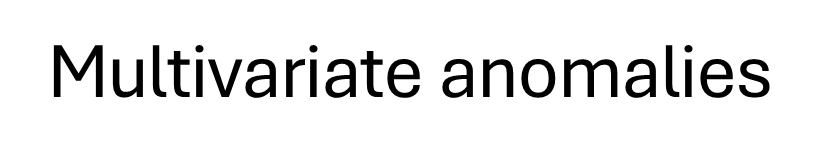
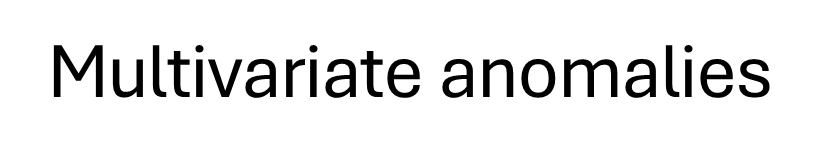

El autor del dataset ha hecho publico un autoencoder LSTM que ha sido entrenado con los datos, vamos a usar ese autoencoder para detectar anomalias, en base a la diferencia entre los datos originales y los reconstruidos.

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM

class CompatibleLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop('time_major', None)  # Remove unsupported argument
        super().__init__(*args, **kwargs)

model = load_model('/kaggle/input/model/tensorflow2/default/1/model.h5', custom_objects={'LSTM': CompatibleLSTM},compile=False)

2025-05-23 20:02:41.947614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748030561.965020     876 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748030561.970464     876 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748030565.032823     876 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748030565.033546     876 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Si la diferencia entre la prediccion y el dato real supera el percentil 95, entonces lo consideramos como anomalia.

In [6]:
import numpy as np

X_input = df[best_channels]      # Original input
X_input = np.expand_dims(X_input, axis=1) # New shape: (32, 1, 6)
print("a")
reconstructed  = model.predict(X_input,batch_size=32)
print("a")

a
    61/460261 ━━━━━━━━━━━━━━━━━━━━ 12:47 2ms/step    

I0000 00:00:1748030567.819460     935 cuda_dnn.cc:529] Loaded cuDNN version 90300


460261/460261 ━━━━━━━━━━━━━━━━━━━━ 755s 2ms/step
a


In [7]:
reconstruction_errors = np.mean(np.square(X_input - reconstructed), axis=(1, 2))
threshold = np.percentile(reconstruction_errors, 95)  # 95th percentile
anomalies = reconstruction_errors > threshold

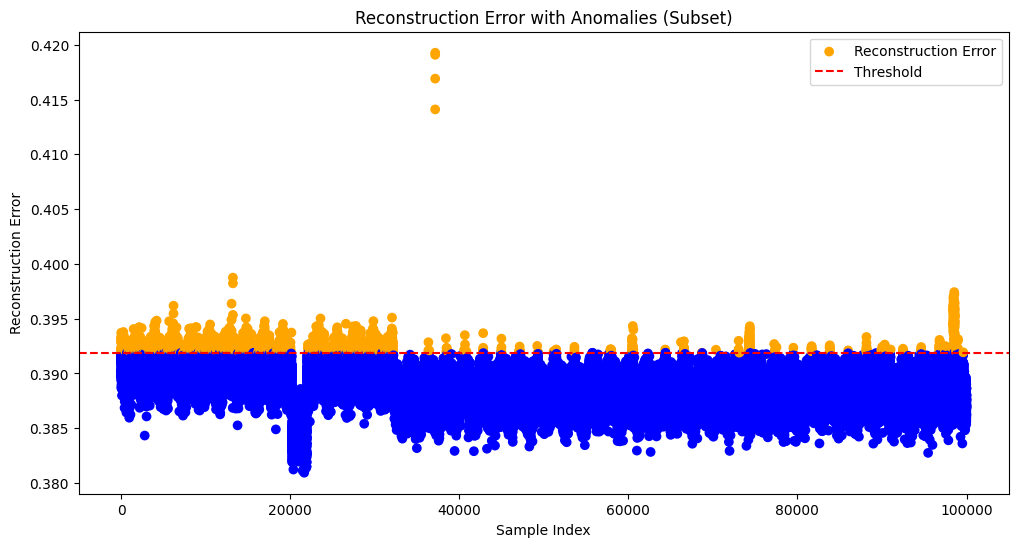

In [18]:
import matplotlib.pyplot as plt

# User-defined range
start_idx = 0  # Replace with desired start index
end_idx = 100000   # Replace with desired end index

errors_slice = reconstruction_errors[start_idx:end_idx]
anomalies_slice = df['is_anomaly'][start_idx:end_idx]

colors = ['orange' if a == 1 else 'blue' for a in anomalies_slice]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(range(start_idx, end_idx), errors_slice, c=colors, label='Reconstruction Error')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

plt.title('Reconstruction Error with Anomalies (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


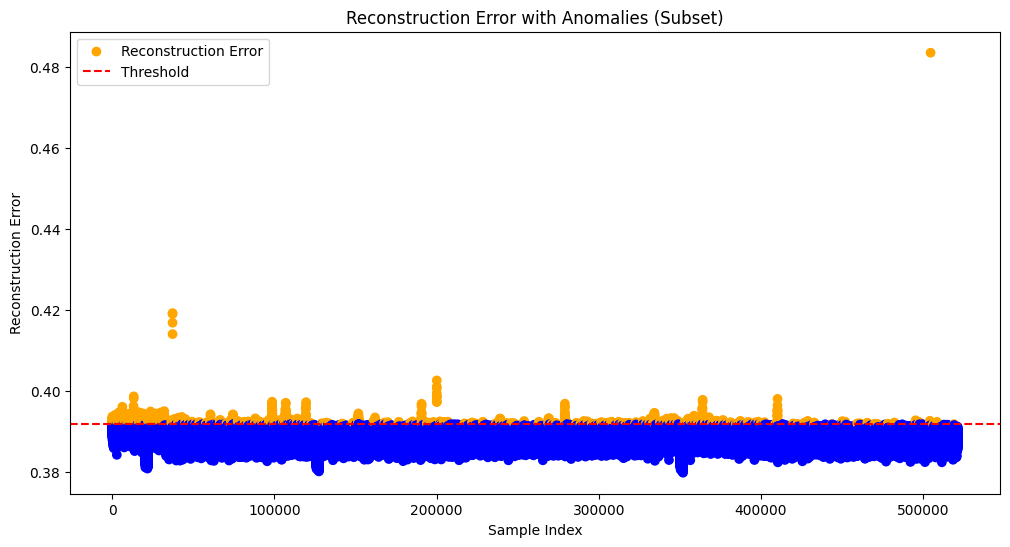

In [13]:
import matplotlib.pyplot as plt

# User-defined range
start_idx = 0  # Replace with desired start index
end_idx = len(df)    # Replace with desired end index

errors_slice = reconstruction_errors[start_idx:end_idx]
anomalies_slice = df['is_anomaly'][start_idx:end_idx]

colors = ['orange' if a == 1 else 'blue' for a in anomalies_slice]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(range(start_idx, end_idx), errors_slice, c=colors, label='Reconstruction Error')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

plt.title('Reconstruction Error with Anomalies (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()



podemos observar como cuando la mayoria de los datos formados por la diferencia entre los valores normales y los obtenidos tras el autoencoder es muy grande, entonces se considera una anomalia, y parece que existe una . 

Realizamos las predicciones en test.

In [ ]:
X_test_input

In [12]:
test_df = pd.read_parquet("/kaggle/input/competicion-q-no-me-deja-sino/data/test.parquet")
X_test_input = test_df[best_channels]        # Original input
X_test_input = np.expand_dims(X_test_input, axis=1) # New shape: (32, 1, 6)


reconstructed  = model.predict(X_test_input)

reconstruction_errors = np.mean(np.square(X_test_input - reconstructed), axis=(1, 2))
threshold = np.percentile(reconstruction_errors, 99)  # 95th percentile
anomalies = reconstruction_errors > threshold

# Example arrays
ids = test_df['id']

# Create DataFrame
df = pd.DataFrame({
    'id': ids,
    'is_anomaly': anomalies
})
df.to_parquet('output_file.parquet', index=False)

16290/16290 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
